In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from pathlib import Path
from sklearn.tree import DecisionTreeRegressor
from treeinterpreter import treeinterpreter
from utils import draw_tree, waterfallplot
pd.set_option('display.max_columns', None)
%matplotlib inline

# Data

from http://data.princeton.edu/wws509/datasets/#salary

These are the salary data used in Weisberg's book, consisting of observations on six variables for 52 tenure-track professors in a small college. The variables are:

    sx = Sex
    rk = Rank
    yr = Number of years in current rank
    dg = Highest degree
    yd = Number of years since highest degree was earned
    sl = Academic year salary, in dollars. 

## Read data

In [2]:
df = pd.read_csv('data/salaries_data.dat', sep='\s+')
print(df.shape)
df.head()

(52, 6)


,sx,rk,yr,dg,yd,sl
0,male,full,25,doctorate,35,36350
1,male,full,13,doctorate,22,35350
2,male,full,10,doctorate,23,28200
3,female,full,7,doctorate,27,26775
4,male,full,19,masters,30,33696


## Explore variables

In [3]:
# numerical variables
df.describe()

,yr,yd,sl
count,52.000000,52.000000,52.000000
mean,7.480769,16.115385,23797.653846
std,5.507536,10.222340,5917.289154
min,0.000000,1.000000,15000.000000
25%,3.000000,6.750000,18246.750000
50%,7.000000,15.500000,23719.000000
75%,11.000000,23.250000,27258.500000
max,25.000000,35.000000,38045.000000


In [4]:
# categorical variables
cat_vars = ['sx', 'rk', 'dg']
for var in cat_vars:
    print(f'{var}: ', df[var].unique())

sx:  ['male' 'female']
rk:  ['full' 'associate' 'assistant']
dg:  ['doctorate' 'masters']


In [5]:
# view counts
print(f'total={len(df)}')
for var in cat_vars:
    print(f'{var}: ', [f'{v}={c} ({c/len(df):.2})' for v,c in zip(*np.unique(df[var], return_counts=True))])

total=52
sx:  ['female=14 (0.27)', 'male=38 (0.73)']
rk:  ['assistant=18 (0.35)', 'associate=14 (0.27)', 'full=20 (0.38)']
dg:  ['doctorate=34 (0.65)', 'masters=18 (0.35)']


## Preprocess

In [6]:
# Convert to category type
cat_dict = dict()
for var in cat_vars:
    df[var] = df[var].astype('category')
    cat_dict[var] = {i+1:c for i,c in enumerate(df[var].cat.categories)}
    df[var] = df[var].cat.codes+1

pprint(cat_dict)  
df.head()

{'dg': {1: 'doctorate', 2: 'masters'},
 'rk': {1: 'assistant', 2: 'associate', 3: 'full'},
 'sx': {1: 'female', 2: 'male'}}


,sx,rk,yr,dg,yd,sl
0,2,3,25,1,35,36350
1,2,3,13,1,22,35350
2,2,3,10,1,23,28200
3,1,3,7,1,27,26775
4,2,3,19,2,30,33696


In [7]:
x = df.drop('sl', axis=1)
y = df['sl']

# Decision tree

In [8]:
m = DecisionTreeRegressor(max_depth=3)
m.fit(x, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [9]:
# R^2: coefficient of determination
m.score(x, y)

0.8878392660809423

# View the tree

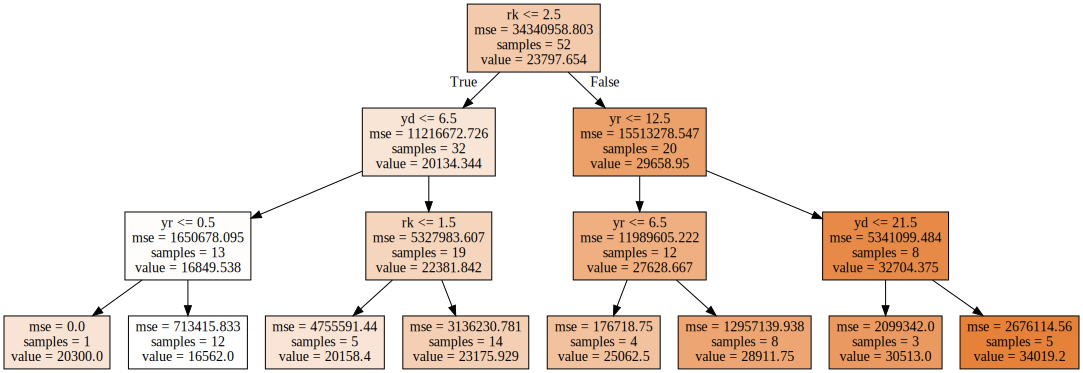

In [10]:
draw_tree(m, x)

# Using dummies

In [11]:
df = pd.read_csv('data/salaries_data.dat', sep='\s+')
df = pd.get_dummies(df)
df.head()

,yr,yd,sl,sx_female,sx_male,rk_assistant,rk_associate,rk_full,dg_doctorate,dg_masters
0,25,35,36350,0,1,0,0,1,1,0
1,13,22,35350,0,1,0,0,1,1,0
2,10,23,28200,0,1,0,0,1,1,0
3,7,27,26775,1,0,0,0,1,1,0
4,19,30,33696,0,1,0,0,1,0,1


In [12]:
x = df.drop('sl', axis=1)
y = df['sl']
m = DecisionTreeRegressor(max_depth=3)
m.fit(x, y)
m.score(x, y)

0.8878392660809423

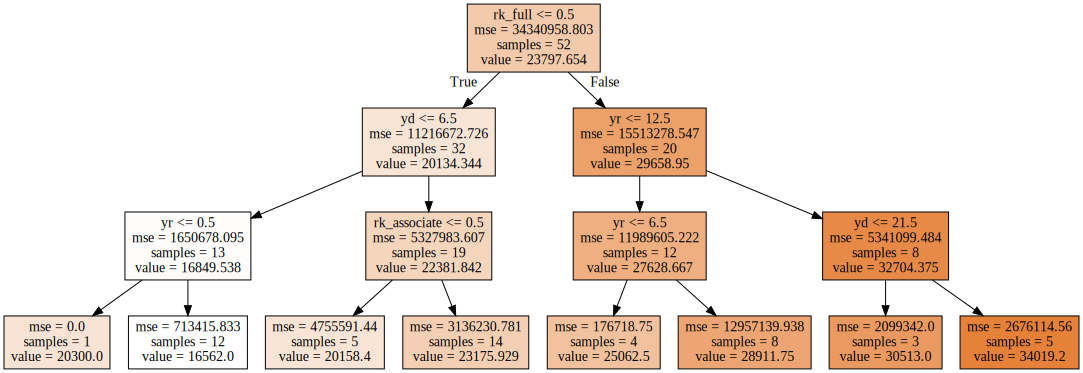

In [13]:
draw_tree(m, x)

# Feature importance

In [14]:
m = DecisionTreeRegressor()
m.fit(x, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [15]:
feat_importance = pd.DataFrame({'cols':x.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)
feat_importance

,cols,imp
6,rk_full,0.625795
1,yd,0.198328
0,yr,0.130797
4,rk_assistant,0.018802
3,sx_male,0.018347
8,dg_masters,0.006288
7,dg_doctorate,0.001225
2,sx_female,0.000418
5,rk_associate,0.000000


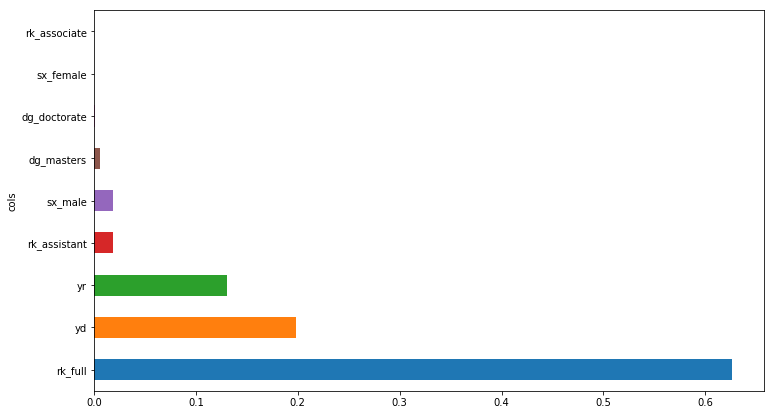

In [16]:
feat_importance.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False);

# Tree interpreter

In [17]:
sample = x.sample()
sample

,yr,yd,sx_female,sx_male,rk_assistant,rk_associate,rk_full,dg_doctorate,dg_masters
37,4,4,0,1,1,0,0,1,0


In [18]:
prediction, bias, contributions = treeinterpreter.predict(m, sample)
prediction[0], bias[0], y[sample.index[0]]

(17347.5, 23797.653846153848, 17095)

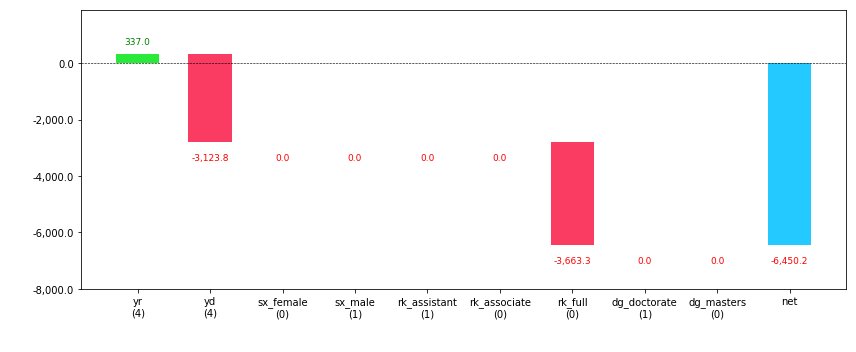

In [19]:
waterfallplot(sample, contributions[0], size=(12,5));